In [1]:
%matplotlib inline

from IPython import display
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# overwrite ipython defaults
plt.rcParams["figure.facecolor"] = '17344A'
plt.rcParams["axes.facecolor"] = '17344A'
plt.rcParams["figure.figsize"] = (10, 8)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# List all the files in the data folder
!ls data

69064b7a-4ac1-4e2e-9222-884909a64978.csv  yelp_academic_dataset_checkin.json
AllViolations.csv			  yelp_academic_dataset_review.json
business_id.txt				  yelp_academic_dataset_tip.json
restaurant_ids_to_yelp_ids.csv		  yelp_academic_dataset_user.json
yelp_academic_dataset_business.json


In [2]:
id_map = pd.read_csv("data/restaurant_ids_to_yelp_ids.csv")
id_dict = {}

# each Yelp ID may correspond to up to 4 Boston IDs
for i, row in id_map.iterrows():
    # get the Boston ID
    boston_id = row["restaurant_id"]
    
    # get the non-null Yelp IDs
    non_null_mask = ~pd.isnull(row.ix[1:])
    yelp_ids = row[1:][non_null_mask].values
    
    for yelp_id in yelp_ids:
        id_dict[yelp_id] = boston_id

In [3]:
with open("data/yelp_academic_dataset_review.json", 'r') as review_file:
    # the file is not actually valid json since each line is an individual
    # dict -- we will add brackets on the very beginning and ending in order
    # to make this an array of dicts and join the array entries with commas
    review_json = '[' + ','.join(review_file.readlines()) + ']'

# read in the json as a DataFrame
reviews = pd.read_json(review_json)

# drop columns that we won't use
reviews.drop(['review_id', 'type', 'user_id', 'votes'], 
             inplace=True, 
             axis=1)

# replace yelp business_id with boston restaurant_id
map_to_boston_ids = lambda yelp_id: id_dict[yelp_id] if yelp_id in id_dict else np.nan
reviews.business_id = reviews.business_id.map(map_to_boston_ids)

# rename first column to restaurant_id so we can join with boston data
reviews.columns = ["restaurant_id", "date", "stars", "text"]    

# drop restaurants not found in boston data
reviews = reviews[pd.notnull(reviews.restaurant_id)]

reviews.head()

restaurant_id       date  stars  \
0      N6Ok7qOx 2005-08-26      3   
1      N6Ok7qOx 2005-11-23      3   
2      N6Ok7qOx 2005-11-23      3   
3      N6Ok7qOx 2006-02-24      5   
4      N6Ok7qOx 2007-09-06      3   

                                                text  
0  This is a pretty typical cafe.  The sandwiches...  
1  I agree with other reviewers - this is a prett...  
2  Decent enough food, but very overpriced. Just ...  
3  The muffins are great...esp the blueberry!  I ...  
4  Well, well, well, look at me reviewing the res...

In [4]:
with open("data/yelp_academic_dataset_business.json", 'r') as biz_file:
    # the file is not actually valid json since each line is an individual
    # dict -- we will add brackets on the very beginning and ending in order
    # to make this an array of dicts and join the array entries with commas
    biz_json = '[' + ','.join(biz_file.readlines()) + ']'

# read in the json as a DataFrame
biz_info = pd.read_json(biz_json)

# drop columns that we won't use
biz_info.drop(['city', 'open','name','state','type','full_address','latitude','longitude','hours'], 
             inplace=True, 
             axis=1)

# replace yelp business_id with boston restaurant_id
map_to_boston_ids = lambda yelp_id: id_dict[yelp_id] if yelp_id in id_dict else np.nan
biz_info.business_id = biz_info.business_id.map(map_to_boston_ids)

# rename first column to restaurant_id so we can join with boston data
biz_info.columns = ["attributes","restaurant_id", "categories", "neighborhoods", "review_count","stars"]    

# drop restaurants not found in boston data
biz_info = biz_info[pd.notnull(biz_info.restaurant_id)]
biz_info.head()

attributes restaurant_id  \
0  {u'Price Range': 1, u'Accepts Credit Cards': T...      N6Ok7qOx   
1  {u'Take-out': True, u'Price Range': 1, u'Outdo...      p03824Om   
2  {u'Take-out': True, u'Price Range': 1, u'Outdo...      8KoAk4E6   
3  {u'Take-out': True, u'Accepts Credit Cards': T...      N6OkKQOx   
4  {u'Take-out': False, u'Accepts Credit Cards': ...      dj3dQao9   

                                          categories            neighborhoods  \
0  [Bakeries, Food, Event Planning & Services, Ca...     [Financial District]   
1  [Delis, Restaurants, Event Planning & Services...            [Beacon Hill]   
2                               [Delis, Restaurants]               [Downtown]   
3  [Food, Sandwiches, Coffee & Tea, Breakfast & B...  [Beacon Hill, Downtown]   
4                      [American (New), Restaurants]               [Downtown]   

   review_count  stars  
0             6    3.5  
1            44    4.0  
2            12    3.0  
3            60    3.5  
4           111    3.5

In [5]:
train_labels = pd.read_csv("data/AllViolations.csv", index_col=0)
submission = pd.read_csv("SubmissionFormat.csv", index_col=0)
train_labels.head()

date restaurant_id  *  **  ***
20619  2006-04-04      6VOp6a3L  7   0    2
10144  2006-10-04      1JEbP4oR  0   0    0
19634  2006-10-16      Pk3w02od  6   1    2
24797  2006-10-19      1JEbP4oR  0   0    0
20253  2006-11-17      N6OkmQ3x  0   0    0

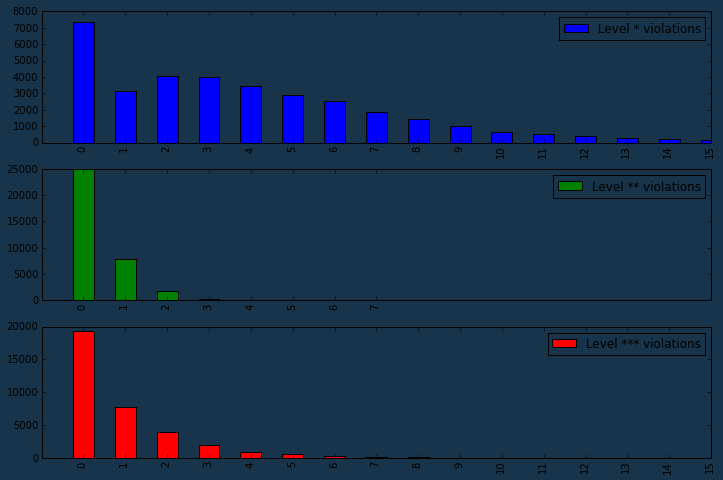

In [6]:
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(12, 8)

for i, label in enumerate(['*', '**', '***']):
    data = train_labels[label]
    vc = data.value_counts()
    idxs = sorted(vc.index)
    vc[idxs].plot(kind="bar",
                  ax=axs[i],
                  xlim=(-1, 15),
                  color=plt.rcParams['axes.color_cycle'][i],
                  grid=False,
                  label='Level {} violations'.format(label))
    axs[i].legend()


In [7]:
# function to compile the possible options of a certain column
def compile_list(columnname):
    out = [];
    for i,thisbiz in enumerate(biz_info[columnname]):
        for j,thisbizinfo in enumerate(thisbiz):
            if thisbizinfo not in out:
                out.append(thisbizinfo)                
    return out;

In [8]:
# find all possible categories, neighborhood, attributes
category_list = compile_list('categories')
neighborhood_list = compile_list('neighborhoods')
attribute_list = compile_list('attributes')

In [9]:
# check the missing date % of each attribute
numbiz = len(biz_info)
noinfo_percent_list = [0.]*len(attribute_list);
for i,attri_name in enumerate(attribute_list):
    noinfo_count = 0;
    for j,thisbiz in enumerate(biz_info['attributes']):
        if attri_name not in thisbiz.keys():
            noinfo_count = noinfo_count+1;
    noinfo_percent_list[i] = noinfo_count*1.0/numbiz;
    
# sort the attributes by their missing percentage    
sorted_index = sorted(range(len(noinfo_percent_list)), key=lambda k: noinfo_percent_list[k]);
for i,ind in enumerate(sorted_index):
    print attribute_list[ind], noinfo_percent_list[ind]

Price Range 0.0235478806907
Accepts Credit Cards 0.0277341705913
Parking 0.0429094714809
Outdoor Seating 0.0915750915751
Good For Groups 0.124542124542
Wheelchair Accessible 0.126635269492
Alcohol 0.153846153846
Attire 0.164311878598
Good for Kids 0.168498168498
Take-out 0.172684458399
Waiter Service 0.178440607012
Delivery 0.186813186813
Takes Reservations 0.187336473051
Good For 0.189429618001
Noise Level 0.273155416013
Has TV 0.278911564626
Ambience 0.281527995814
Wi-Fi 0.328100470958
Caters 0.41810570382
Good For Kids 0.580847723705
BYOB/Corkage 0.658817373103
BYOB 0.729984301413
Smoking 0.806384092098
Music 0.810047095761
Coat Check 0.811616954474
Happy Hour 0.8147566719
Corkage 0.819466248038
Good For Dancing 0.824175824176
Order at Counter 0.850340136054
Dogs Allowed 0.9094714809
Open 24 Hours 0.919413919414
Drive-Thru 0.953950811094
Payment Types 0.973835688121
Dietary Restrictions 0.98063840921
Ages Allowed 0.990580847724
By Appointment Only 0.997383568812


In [10]:
##### we can probably make a cut at "Ambience" (missing percent 28.15%)
# we can get rid of Parking (which as a lot of options)
attribute_list_thin = [];
cutoff_percent = 0.29;
for i,percent  in enumerate(noinfo_percent_list):
    if percent<cutoff_percent and attribute_list[i]!='Parking':
        attribute_list_thin.append(attribute_list[i])
attribute_list_thin

[u'Price Range',
 u'Accepts Credit Cards',
 u'Wheelchair Accessible',
 u'Take-out',
 u'Outdoor Seating',
 u'Noise Level',
 u'Ambience',
 u'Has TV',
 u'Good For',
 u'Takes Reservations',
 u'Attire',
 u'Waiter Service',
 u'Good for Kids',
 u'Good For Groups',
 u'Delivery',
 u'Alcohol']

In [ ]:
###numbers
#Price Range

###boolean
#Accepts Credit Cards
#Take-out
#Outdoor Seating
#Wheelchair Accessible
#Has TV
#Takes Reservations
#Waiter Service
#Good For Kids
#Good for Groups
#Delivery

###words
#Attire
#Noise Level
#Alcohol

###needs to expand
#Ambience
#Good for



In [29]:
biz_info['price_range'] =list(range(len(biz_info.index)))
#set default value to -1, will be needed to identify imputation cells
biz_info.price_range = -1
#enter all the existing price_range info
for i,index in enumerate(biz_info.index):
    thisrow = biz_info.attributes[index]
    if ('Price Range' in thisrow):        
        biz_info.price_range[index] = thisrow['Price Range']  

In [42]:
ambiencelist = [];
for i,index in enumerate(biz_info.index):
    thisrow = biz_info.attributes[index]
    if ('Ambience' in thisrow):  
        for style in thisrow['Ambience']:
               if ('ambience_'+style) not in ambiencelist:
                    ambiencelist.append('ambience_'+style)
goodforlist = [];
for i,index in enumerate(biz_info.index):
    thisrow = biz_info.attributes[index]
    if ('Good For' in thisrow):  
        for style in thisrow['Good For']:
               if ('goodfor_'+style) not in goodforlist:
                    goodforlist.append('goodfor_'+style)

In [43]:
ambiencelist

[u'ambience_romantic',
 u'ambience_intimate',
 u'ambience_touristy',
 u'ambience_hipster',
 u'ambience_divey',
 u'ambience_classy',
 u'ambience_trendy',
 u'ambience_upscale',
 u'ambience_casual']

In [45]:
goodforlist

[u'goodfor_dessert',
 u'goodfor_latenight',
 u'goodfor_lunch',
 u'goodfor_dinner',
 u'goodfor_breakfast',
 u'goodfor_brunch']

In [ ]:
attirelist = [];
for i,index in enumerate(biz_info.index):
    thisrow = biz_info.attributes[index]
    if ('Attire' in thisrow):        
        if thisrow['Attire']  not in attirelist:
            attirelist.append(thisrow['Attire'])

In [47]:
alcohollist = [];
for i,index in enumerate(biz_info.index):
    thisrow = biz_info.attributes[index]
    if ('Alcohol' in thisrow):        
        if thisrow['Alcohol']  not in alcohollist:
            alcohollist.append(thisrow['Alcohol'])

In [48]:
alcohollist

[u'none', u'full_bar', u'beer_and_wine']

In [50]:
noiselist = [];
for i,index in enumerate(biz_info.index):
    thisrow = biz_info.attributes[index]
    if ('Noise Level' in thisrow):        
        if thisrow['Noise Level']  not in noiselist:
            noiselist.append(thisrow['Noise Level'])

In [51]:
noiselist

[u'average', u'quiet', u'loud', u'very_loud']

In [54]:
train_labels.head()

date restaurant_id  *  **  ***
20619  2006-04-04      6VOp6a3L  7   0    2
10144  2006-10-04      1JEbP4oR  0   0    0
19634  2006-10-16      Pk3w02od  6   1    2
24797  2006-10-19      1JEbP4oR  0   0    0
20253  2006-11-17      N6OkmQ3x  0   0    0

In [79]:
train_labels[train_labels.restaurant_id==biz_info.restaurant_id[1907]]

date restaurant_id  *  **  ***
22896  2010-12-15      WwOaKB3B  0   0    0
26529  2011-02-10      WwOaKB3B  3   0    3
17805  2011-02-18      WwOaKB3B  3   0    3
2995   2011-08-29      WwOaKB3B  2   0    0
13934  2011-09-02      WwOaKB3B  2   0    0
22752  2012-05-10      WwOaKB3B  3   0    0
2204   2012-05-29      WwOaKB3B  3   0    0
5292   2012-12-30      WwOaKB3B  0   0    0
12836  2013-04-11      WwOaKB3B  4   0    1
20949  2013-04-22      WwOaKB3B  4   0    1
2657   2013-11-21      WwOaKB3B  1   0    1
28797  2013-12-04      WwOaKB3B  1   0    1
24180  2014-07-10      WwOaKB3B  0   0    0
34827  2015-05-07      WwOaKB3B  1   0    0
34414  2015-05-15      WwOaKB3B  1   0    0

In [81]:
category_list

[u'Bakeries',
 u'Food',
 u'Event Planning & Services',
 u'Caterers',
 u'Delis',
 u'Restaurants',
 u'Sandwiches',
 u'Coffee & Tea',
 u'Breakfast & Brunch',
 u'American (New)',
 u'Burgers',
 u'Fast Food',
 u'Donuts',
 u'American (Traditional)',
 u'Pizza',
 u'Gluten-Free',
 u'Bars',
 u'Gay Bars',
 u'Nightlife',
 u'Sushi Bars',
 u'Chinese',
 u'Falafel',
 u'Mediterranean',
 u'Pubs',
 u'Bagels',
 u'Italian',
 u'Salad',
 u'Arts & Entertainment',
 u'Music Venues',
 u'Thai',
 u'Mexican',
 u'Lounges',
 u'Seafood',
 u'Irish',
 u'Karaoke',
 u'Dive Bars',
 u'Ice Cream & Frozen Yogurt',
 u'Venues & Event Spaces',
 u'Buffets',
 u'Cafes',
 u'French',
 u'Chicken Wings',
 u'Sports Bars',
 u'Middle Eastern',
 u'Hotels',
 u'Hotels & Travel',
 u'Specialty Food',
 u'Ethnic Food',
 u'Steakhouses',
 u'Wine Bars',
 u'Adult Entertainment',
 u'Museums',
 u'Art Galleries',
 u'Shopping',
 u'Desserts',
 u'Dance Clubs',
 u'African',
 u'Moroccan',
 u'Diners',
 u'Cuban',
 u'Caribbean',
 u'Soul Food',
 u'Portuguese',
 